# SmartSifter

In [48]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st

## SDLEアルゴリズム

In [2]:
random.seed(0)
T = 100000
x = np.array([math.floor(random.random()*6) for i in range(T)])

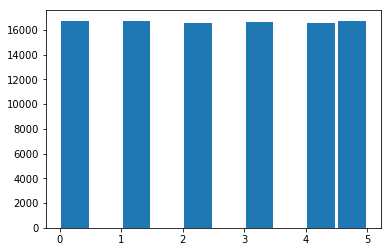

In [3]:
plt.hist(x, rwidth=0.9)
plt.show()

In [4]:
class SDLE:
    def __init__(self, r, beta, M, T):
        """
        """
        self.r = r
        self.beta = beta
        self.M = M
        self.T = T
        
        self.count = np.zeros((T+1, M))
        self.T_t = np.zeros((T+1, M))
        self.prob = np.zeros((T+1, M))
        
        self.t = 1
    
    def update(self, x_t):
        """
        オンライン学習
        """
        for i in range(self.M):
            delta = 0
            if i == x_t:
                delta = 1

            self.T_t[self.t, i] = (1 - self.r) * self.T_t[self.t-1, i] + delta
            self.count[self.t, i] = self.count[self.t-1, i] + delta
            if self.r == 0:
                q = (self.T_t[self.t, i] + self.beta) / (self.t + self.M * self.beta)
                # self.prob[self.t, i] = q / self.count[self.t, i]
                # self.prob[self.t, i] = q
            else:
                q = (self.T_t[self.t, i] + self.beta) / ((1 - (1 - self.r) ** self.t) / self.r + self.M * self.beta)
                # self.prob[self.t, i] = q
                # self.prob[self.t, i] = q / self.count[self.t, i]
            
            if not self.count[self.t, i] == 0:
                self.prob[self.t, i] = q / self.count[self.t, i]

        self.t += 1
    
    def train(self, x):
        """
        バッチ学習
        """
        while self.t <= self.T:
            self.update(x[self.t-1])

In [5]:
r = 0.1
beta = 1
M = len(np.unique(x))

sdle = SDLE(r, beta, M, T)
# print("t = %s" % sdle.t)
# print("count:\n", sdle.count)
# print("prob:\n",sdle.prob)

In [6]:
sdle.train(x)
# for idx in x:
#     sdle.update(idx)

In [7]:
p = sdle.prob[-1] * (1/sdle.prob[-1].sum())
p

array([ 0.23835192,  0.09524788,  0.17722938,  0.18422095,  0.15866785,
        0.14628202])

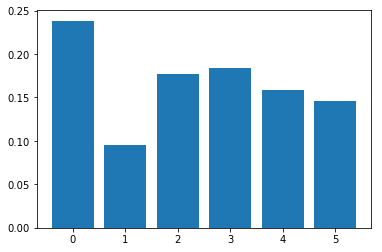

In [8]:
plt.bar(range(6), p)
plt.show()

## SDEMアルゴリズム

In [15]:
tmp = np.arange(0, np.pi*2, 0.01)
y = np.array([np.sin(tmp), np.cos(tmp)]).T

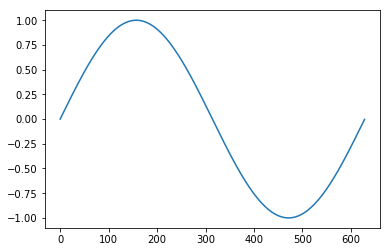

In [16]:
plt.plot(y.T[0])
plt.show()

In [42]:
class SDEM:
    def __init__(self, r, alpha, k, T, d):
        """
        """
        self.r = r
        self.alpha = alpha
        self.k = k
        self.T = T + 1
        self.d = d
        
        self.mu = np.zeros((self.T, self.k, self.d))
        self.mu_ = np.zeros((self.T, self.k, self.d))
        self.c = np.zeros((self.T, self.k))
        self.Lambda = np.zeros((self.T, self.k, self.d, self.d))
        self.Lambda_ = np.zeros((self.T, self.k, self.d, self.d))
        
        for i in range(self.k):
            self.mu_[0, i] = np.random.uniform(low=-1.0, high=1.0, size=2)
            self.mu[0, i] = np.random.uniform(low=-1.0, high=1.0, size=2)
            self.c[0, i] = 1 / self.k
            self.Lambda_[0, i] = np.identity(self.d) * 0.1
            self.Lambda[0, i] = np.copy(self.Lambda_[0, i])
        
        self.t = 1
    
    def update(self, idy):
        """
        オンライン学習
        """
        for i in range(self.k):
            t = self.t
            p_tmp = 1 / ((2 * np.pi) *+ (self.d/2) * np.linalg.det(self.Lambda[t-1, i])**(0.5))
            p = p_tmp * np.exp(-0.5 * (np.dot(np.dot((idy - self.mu[t-1, i]).T, np.linalg.inv(self.Lambda[t-1, i])), (idy - self.mu[t-1, i]))))
            
            gamma = (1 - self.alpha * self.r) * ((self.c[t-1, i] * p) / (self.c[t-1].sum() * p)) + (self.alpha * self.r) / self.k
            self.c[t, i] = (1 - self.r) * self.c[t-1, i] + self.r * gamma
            self.mu_[t, i] = (1 - self.r) * self.mu_[t-1, i] + self.r * gamma * idy
            self.mu[t, i] = self.mu_[t, i] / self.c[t, i]
            self.Lambda_[t, i] = (1 - self.r) * self.Lambda_[t-1, i] + self.r * gamma * np.dot(idy, idy.T)
            self.Lambda[t, i] = self.Lambda_[t, i] / self.c[t, i] -self.mu[t, i] * self.mu[t, i].T
            
        self.t += 1
    
    def train(self, y):
        """
        バッチ学習
        """
        while self.t < self.T:
            self.update(y[self.t-1])

In [43]:
alpha = 1.0
r = 0.1
k = 6
T = y.shape[0]
d = y.shape[1]

sdem = SDEM(r, alpha, k, T, d)

In [44]:
sdem.train(y)

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1776: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [47]:
sdem.Lambda[2]

array([[[ nan,  nan],
        [ nan,  nan]],

       [[ nan,  nan],
        [ nan,  nan]],

       [[ nan,  nan],
        [ nan,  nan]],

       [[ nan,  nan],
        [ nan,  nan]],

       [[ nan,  nan],
        [ nan,  nan]],

       [[ nan,  nan],
        [ nan,  nan]]])

In [37]:
sigma = np.asanyarray(
        [ [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]] ])

In [40]:
sigma

array([[[ 0.1,  0. ],
        [ 0. ,  0.1]],

       [[ 0.1,  0. ],
        [ 0. ,  0.1]],

       [[ 0.1,  0. ],
        [ 0. ,  0.1]]])